In [1]:
# Numpy and Pandas
import numpy as np 
import pandas as pd


# Spacy, Nltk, Textblob, regex
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import re

# visualizations : seaborn, matplotlib, wordcloud
import seaborn as sns
import matplotlib.style as style 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# sklearn 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")

# Scipy Stats
from scipy.stats import ttest_ind

# eli5 => ELI5 is a Python package which helps to debug machine learning classifiers and explain their predictions.
# Provides support for sklearn, keras, XGboost, Light GBM
import eli5

# for removing profanities
from better_profanity import profanity

# Reading in the data, Removal of NA, Duplicates, Certain Outliers

In [2]:
# Load the Data in and do some basic duplicate and NA removal
df = pd.read_csv('train-balanced-sarcasm.csv')
comments_df = df.drop_duplicates().reset_index(drop=True) # Remove Duplicate
comments_df = comments_df[ ['label', 'comment', 'subreddit', 
                            'score', 'ups', 'downs', 'parent_comment']] # Keep a certain subset
comments_df = comments_df.dropna(subset = ["comment"]) # drop null observations

# Need to further drop more duplicates
len_duplicates = comments_df.duplicated(subset=['comment', 'parent_comment'], keep=False).sum()
comments_df = comments_df.drop_duplicates(subset=['comment', 'parent_comment'], keep='first')

In [3]:
#Outlier removal using comment_length
comments_df['comment_length'] = comments_df['comment'].apply(lambda x: len(x.split(" ")))
q3, q1 = np.percentile(comments_df['comment_length'], [75 ,25])
iqr = q3 - q1
print(f'Previous length of dataset {len(comments_df)}')
comments_df = comments_df[
    (comments_df['comment_length'] > (q1 - 1.5 * iqr)) &
    (comments_df['comment_length'] < (q3 + 1.5 * iqr))
]
print(f'New length of dataset {len(comments_df)}')

Previous length of dataset 1009962
New length of dataset 973690


In [4]:
# Checking to see balance
sarcasm_df = comments_df[comments_df['label'] == 1].copy().reset_index(drop=True)
no_sarcasm_df = comments_df[comments_df['label'] == 0].copy().reset_index(drop=True)
print(f'The length of the entire dataset is {len(comments_df)}')
print(f'The length of the no sarcasm dataset is {len(no_sarcasm_df)}')
print(f'The length of the sarcasm dataset is {len(sarcasm_df)}')

The length of the entire dataset is 973690
The length of the no sarcasm dataset is 481206
The length of the sarcasm dataset is 492484


# EDA / Feature Extraction : Number of Special Characters

    * We note that sarcastic comments tend to have more special characters compared to non-sarcastic comments
    
    * Hence, we use this as a feature in our model

In [5]:
# Create function to check for special punctuation
def check_special_punctuation(comment):
    pattern = r"(\?|!|\.\.\.)$"
    if re.search(pattern, comment):
        return 1
    else:
        return 0

# check to see the results
sarcasm_df['end_with_special_punctuation'] = sarcasm_df['comment'].apply(check_special_punctuation)
no_sarcasm_df['end_with_special_punctuation'] = no_sarcasm_df['comment'].apply(check_special_punctuation)

# Display the results
print(f"The number of comments that end with special punctuation for sarcastic comments are {sum(sarcasm_df['end_with_special_punctuation'])}")
print(f"The number of comments that end with special punctuation for non sarcastic comments are {sum(no_sarcasm_df['end_with_special_punctuation'])}")

The number of comments that end with special punctuation for sarcastic comments are 139286
The number of comments that end with special punctuation for non sarcastic comments are 101685


In [6]:
# Add the new feature since it is useful
comments_df['end_with_special_punctuation'] = comments_df['comment'].apply(lambda x : check_special_punctuation(x))
comments_df.head(3)

,label,comment,subreddit,score,ups,downs,parent_comment,comment_length,end_with_special_punctuation
0,0,NC and NH.,politics,2,-1,-1,"Yeah, I get that argument. At this point, I'd ...",3,0
1,0,You do know west teams play against west teams...,nba,-4,-1,-1,The blazers and Mavericks (The wests 5 and 6 s...,14,1
2,0,"They were underdogs earlier today, but since G...",nfl,3,3,0,They're favored to win.,19,0


# EDA / Feature Extraction : Proportion of sarcasm within subreddit

### Data Shows that some subreddits are more sarcastic than others

In [7]:
# We find that some subreddits have low subreddit count
subreddit_counts = comments_df.groupby('subreddit').size().sort_values()
print(len(subreddit_counts))

# so we remove them for analysis
filtered_subreddit_counts = subreddit_counts[subreddit_counts > 66.439285]
print(len(filtered_subreddit_counts))

# filter
subreddit_df = comments_df[comments_df['subreddit'].isin(filtered_subreddit_counts.index)]

14663
1227


In [8]:
# Gives you the number of observations for each subreddit
total_comments_per_subreddit = (subreddit_df.groupby('subreddit').size().reset_index(name='total_comments'))

# Gives you the number of observations with label = 1 for each subreddit
sarcasm_subreddit = (subreddit_df[subreddit_df['label'] == 1].groupby('subreddit').size().reset_index(name='sarcasm_comments'))

# Gives you the number of observations with label = 0 for each subreddit
no_sarcasm_subreddit = (subreddit_df[subreddit_df['label'] == 0].groupby('subreddit').size().reset_index(name='no_sarcasm_comments'))

In [9]:
# this gives you : for each distinct subreddit, the count of comments, the count of label = 0, the count of label = 1
subreddit_label_proportions = pd.merge(total_comments_per_subreddit, sarcasm_subreddit, on='subreddit')
subreddit_label_proportions = pd.merge(subreddit_label_proportions, no_sarcasm_subreddit, on='subreddit')

In [10]:
# Compute the proportion statistics
subreddit_label_proportions['sarcasm_prop'] = subreddit_label_proportions['sarcasm_comments'] / subreddit_label_proportions['total_comments']
subreddit_label_proportions['no_sarcasm_prop'] = subreddit_label_proportions['no_sarcasm_comments'] / subreddit_label_proportions['total_comments']

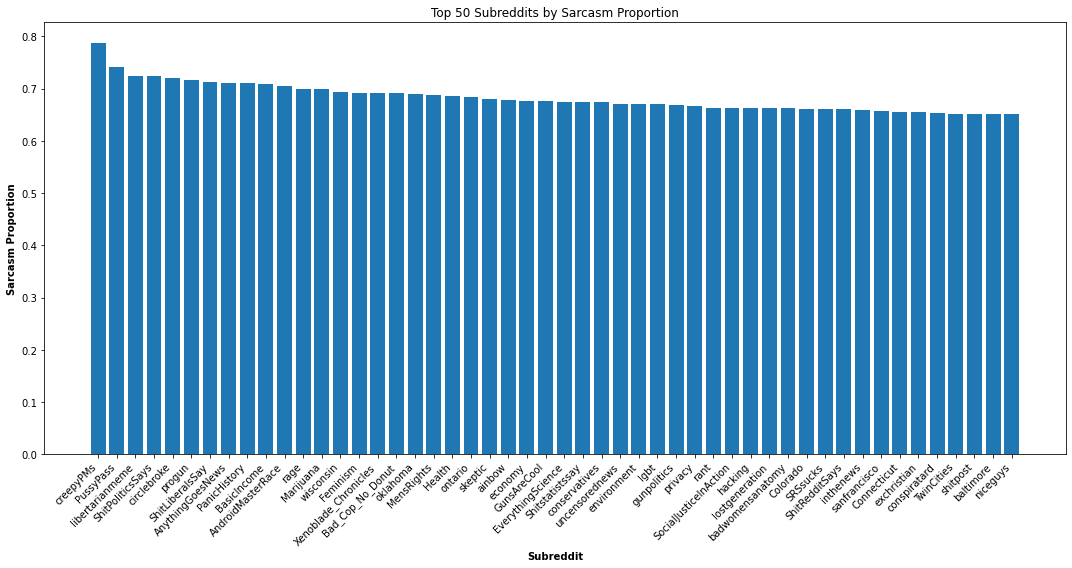

In [11]:
# Get the top 50 most sarcastic subreddits
subreddit_label_proportions = subreddit_label_proportions.sort_values(by='sarcasm_prop', ascending=False)

# Plot the results
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(subreddit_label_proportions['subreddit'].head(50), subreddit_label_proportions['sarcasm_prop'].head(50))

ax.set_xticks(range(50))
ax.set_xticklabels(subreddit_label_proportions['subreddit'].head(50), rotation=45, ha='right')
ax.set_ylabel('Sarcasm Proportion', fontweight='bold')
ax.set_xlabel('Subreddit', fontweight='bold')
ax.set_title('Top 50 Subreddits by Sarcasm Proportion')

plt.tight_layout()
plt.show()

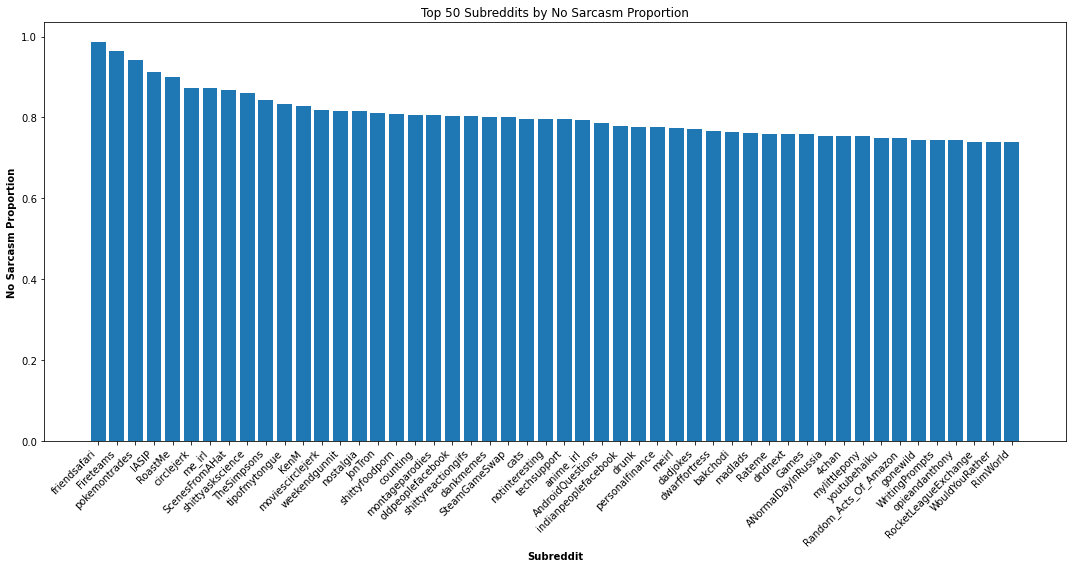

In [12]:
# Get the 50 least sarcastic subreddits
subreddit_label_proportions_2 = subreddit_label_proportions.sort_values(by='no_sarcasm_prop', ascending=False).copy()

# Plot the results
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(subreddit_label_proportions_2['subreddit'].head(50), subreddit_label_proportions_2['no_sarcasm_prop'].head(50))

ax.set_xticks(range(50))
ax.set_xticklabels(subreddit_label_proportions_2['subreddit'].head(50), rotation=45, ha='right')
ax.set_ylabel('No Sarcasm Proportion', fontweight='bold')
ax.set_xlabel('Subreddit', fontweight='bold')
ax.set_title('Top 50 Subreddits by No Sarcasm Proportion')

plt.tight_layout()
plt.show()

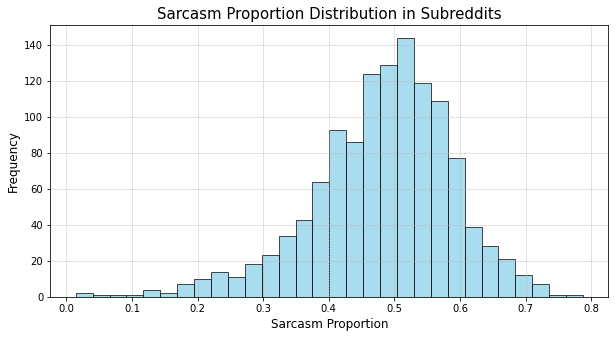

In [13]:
plt.figure(figsize=(10, 5))  # Sets the figure size
plt.hist(subreddit_label_proportions['sarcasm_prop'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Adding aesthetics
plt.title('Sarcasm Proportion Distribution in Subreddits', fontsize=15)
plt.xlabel('Sarcasm Proportion', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Optional: Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

In [14]:
# Create the feature
subreddit_label_proportions = subreddit_label_proportions[['subreddit', 'sarcasm_prop']]
comments_df = pd.merge(comments_df, subreddit_label_proportions, how='left', on='subreddit')

In [15]:
# Mean imputation for observations where sarcasm_prop was not appropriate
comments_df['sarcasm_prop'] = comments_df['sarcasm_prop'].fillna(comments_df['sarcasm_prop'].mean())
comments_df.head(3)

,label,comment,subreddit,score,ups,downs,parent_comment,comment_length,end_with_special_punctuation,sarcasm_prop
0,0,NC and NH.,politics,2,-1,-1,"Yeah, I get that argument. At this point, I'd ...",3,0,0.612595
1,0,You do know west teams play against west teams...,nba,-4,-1,-1,The blazers and Mavericks (The wests 5 and 6 s...,14,1,0.530739
2,0,"They were underdogs earlier today, but since G...",nfl,3,3,0,They're favored to win.,19,0,0.513177


# EDA / Feature Extraction : comment length vs Parent Comment length

In [16]:
# Create the feature first
df2 = comments_df.copy()
df2['parent_length'] = df2['parent_comment'].apply(lambda x : len(x.split(" ")))
df2['comment_parent_ratio'] = df2['comment_length'] / df2['parent_length']

print(df2[df2['label'] == 1]['comment_parent_ratio'].mean())
print(df2[df2['label'] == 0]['comment_parent_ratio'].mean())

0.9687527021989001
0.9714851419979649


In [17]:
def iqr_analysis(series, iqr_tries, series_name):
    for i in iqr_tries:
        # First, calculate IQR and identify outliers for sarcastic comments
        q25, q75 = np.percentile(series, 25), np.percentile(series, 75)
        iqr = q75 - q25

        # Adjusting the series by removing outliers
        outlier_low = q25 - i * iqr
        outlier_high = q75 + i * iqr
        series_adj = series[(series > outlier_low) & (series < outlier_high)]

        # Outlier scores for statistics (using the correct bounds as used for filtering)
        outlier_scores = pd.Series([x for x in series if x < outlier_low or x > outlier_high])

        # Histogram of adjusted scores
        series_adj.hist()
        plt.show()

        # Printing Statistics
        print(f'after removing {outlier_scores.shape[0]} outliers, which is {round(outlier_scores.shape[0]/series.shape[0],2)*100}% original')
        print(f'which have a mean of {outlier_scores.mean()} & median of {outlier_scores.median()}')
        print(f'the mean score of {series_name} is {series_adj.mean()} & median is {series_adj.median()}')

def remove_outliers(series, multiplier):
    q25, q75 = np.percentile(series, 25), np.percentile(series, 75)
    iqr = q75 - q25

    # Adjusting the series by removing outliers
    outlier_low = q25 - multiplier * iqr
    outlier_high = q75 + multiplier * iqr
    series_adj = series[(series > outlier_low) & (series < outlier_high)]
    return series_adj

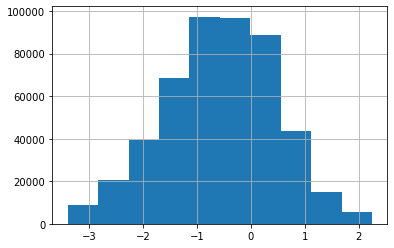

after removing 7639 outliers, which is 2.0% original
which have a mean of -2.0793004570502567 & median of -3.6109179126442243
the mean score of sarcastic c/p/r is -0.5781733644072695 & median is -0.5306282510621704


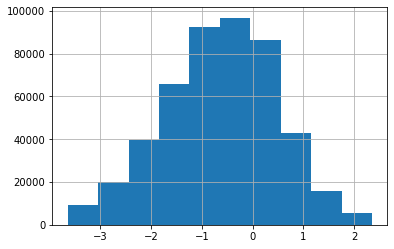

after removing 7413 outliers, which is 2.0% original
which have a mean of -2.395966830290304 & median of -3.871201010907891
the mean score of non-sarcastic c/p/r is -0.6355742738947155 & median is -0.5753641449035618


In [18]:
iqr_analysis(np.log(df2[df2['label'] == 1]['comment_parent_ratio']), [1.5], 'sarcastic c/p/r')
iqr_analysis(np.log(df2[df2['label'] == 0]['comment_parent_ratio']), [1.5], 'non-sarcastic c/p/r')

In [19]:
t_stat, p_value = ttest_ind(remove_outliers(np.log(df2[df2['label'] == 1]['comment_parent_ratio']), 1.5),
                            remove_outliers(np.log(df2[df2['label'] == 0]['comment_parent_ratio']), 1.5))
print(f'p-value: {p_value}')

p-value: 7.767395491888094e-154


In [20]:
comments_df['comment_length'] = comments_df['comment'].apply(lambda x : len(x.split(" ")))
comments_df['parent_length'] = comments_df['parent_comment'].apply(lambda x : len(x.split(" ")))
comments_df['comment_parent_ratio'] = comments_df['comment_length'] / comments_df['parent_length']
comments_df['ln_comment_parent_ratio'] = np.log(comments_df['comment_parent_ratio'])

comments_df = comments_df.drop('parent_length', axis=1)
comments_df = comments_df.drop('comment_length', axis=1)
comments_df = comments_df.drop('comment_parent_ratio', axis=1)

In [21]:
comments_df.head(3)

,label,comment,subreddit,score,ups,downs,parent_comment,end_with_special_punctuation,sarcasm_prop,ln_comment_parent_ratio
0,0,NC and NH.,politics,2,-1,-1,"Yeah, I get that argument. At this point, I'd ...",0,0.612595,-1.734601
1,0,You do know west teams play against west teams...,nba,-4,-1,-1,The blazers and Mavericks (The wests 5 and 6 s...,1,0.530739,-0.656780
2,0,"They were underdogs earlier today, but since G...",nfl,3,3,0,They're favored to win.,0,0.513177,1.558145


# EDA / Feature Extraction : Subjectivity of the Comment and Parent

In [22]:
# Create a function to compute subjectivity
def calculate_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# calculate subjectivity
comments_df['subjectivity_comment'] = comments_df['comment'].apply(lambda x : calculate_subjectivity(x))
comments_df['subjectivity_parent'] = comments_df['parent_comment'].apply(lambda x : calculate_subjectivity(x))

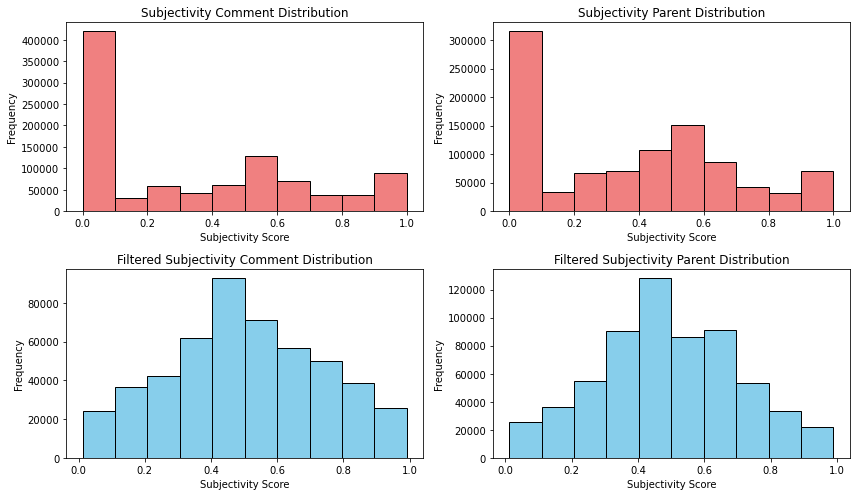

In [23]:
# Make a copy to make modifications on
df2 = comments_df.copy()

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

# Plotting the first histogram (full data for subjectivity_comment)
axs[0, 0].hist(df2['subjectivity_comment'], color="lightcoral", edgecolor='black')
axs[0, 0].set_title('Subjectivity Comment Distribution')
axs[0, 0].set_xlabel('Subjectivity Score')
axs[0, 0].set_ylabel('Frequency')

# Plotting the second histogram (full data for subjectivity_parent)
axs[0, 1].hist(df2['subjectivity_parent'], color="lightcoral", edgecolor='black')
axs[0, 1].set_title('Subjectivity Parent Distribution')
axs[0, 1].set_xlabel('Subjectivity Score')
axs[0, 1].set_ylabel('Frequency')

# Filtering comments != 0 and != 1
comments = df2['subjectivity_comment'][(df2['subjectivity_comment'] != 0) & (df2['subjectivity_comment'] != 1)]
# Plotting the third histogram (filtered subjectivity_comment)
axs[1, 0].hist(comments, color='skyblue', edgecolor='black')
axs[1, 0].set_title('Filtered Subjectivity Comment Distribution')
axs[1, 0].set_xlabel('Subjectivity Score')
axs[1, 0].set_ylabel('Frequency')

# Filtering parents != 0 and != 1
parents = df2['subjectivity_parent'][(df2['subjectivity_parent'] != 0) & (df2['subjectivity_parent'] != 1)]
# Plotting the fourth histogram (filtered subjectivity_parent)
axs[1, 1].hist(parents, color='skyblue', edgecolor='black')
axs[1, 1].set_title('Filtered Subjectivity Parent Distribution')
axs[1, 1].set_xlabel('Subjectivity Score')
axs[1, 1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

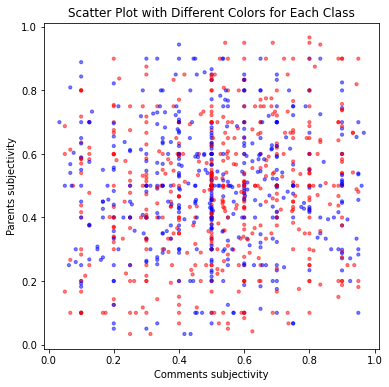

In [24]:
df3 = df2[(df2['subjectivity_comment'] != 0) & 
         (df2['subjectivity_comment'] != 1) & 
         (df2['subjectivity_parent'] != 0) & 
         (df2['subjectivity_parent'] != 1)].copy()

class_to_color = {
    1: 'red',
    0: 'blue',
}
sample_df3 = df3.sample(n=1000)
colors = sample_df3['label'].map(class_to_color)

plt.figure(figsize=(6, 6))

plt.scatter(sample_df3['subjectivity_comment'], sample_df3['subjectivity_parent'], alpha=0.5, s=10, c=colors)
plt.title('Scatter Plot with Different Colors for Each Class')
plt.xlabel('Comments subjectivity')
plt.ylabel('Parents subjectivity')
plt.show()

In [25]:
# Split into suitable groups
df3['subjectivity_comment_thercile'] = pd.qcut(df3['subjectivity_comment'], 
                                               3, 
                                               labels=['c_obj', 'c_neut', 'c_subj'])

# Split into suitable groups
df3['subjectivity_parent_thercile'] = pd.qcut(df3['subjectivity_parent'],
                                              3, 
                                              labels=['p_obj', 'p_neut', 'p_subj'])

# get a dataframe for subjectivity analysis
df_subjectivity = df3[['label', 'comment', 'subjectivity_comment', 'subjectivity_parent', 'subjectivity_comment_thercile','subjectivity_parent_thercile']]
subjectivity_analysis = df_subjectivity.groupby(['label', 'subjectivity_comment_thercile', 'subjectivity_parent_thercile'])['comment'].count().reset_index()

# Create a new column
subjectivity_analysis['subjectivity_comment_thercile'] = subjectivity_analysis['subjectivity_comment_thercile'].astype(str)
subjectivity_analysis['subjectivity_parent_thercile'] = subjectivity_analysis['subjectivity_parent_thercile'].astype(str)
subjectivity_analysis['grp'] = subjectivity_analysis['subjectivity_comment_thercile'] + ' & ' + subjectivity_analysis['subjectivity_parent_thercile']

#Compute the values
category_sums = subjectivity_analysis.groupby('grp')['comment'].transform('sum')
subjectivity_analysis['ratio'] = subjectivity_analysis['comment'] / category_sums


# Pivot the DataFrame to get categories as index and labels as columns
subjectivity_analysis_pivot = subjectivity_analysis.pivot_table(index='grp', 
                                                          columns='label', 
                                                          values='ratio', 
                                                          aggfunc='first')

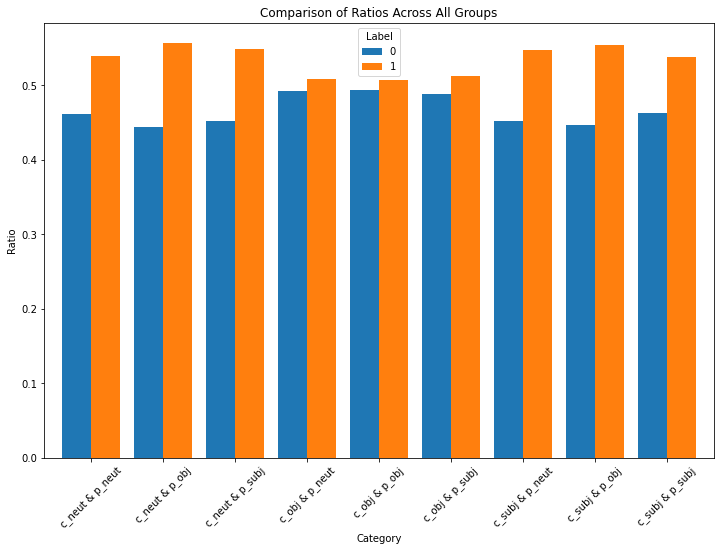

In [26]:
# Plotting the grouped bar chart
subjectivity_analysis_pivot.plot(kind='bar', figsize=(12, 8), width=0.8)
plt.title('Comparison of Ratios Across All Groups')
plt.xlabel('Category')
plt.ylabel('Ratio')
plt.xticks(rotation=45)  # Rotate category labels for better readability
plt.legend(title='Label', labels=['0', '1'])
plt.show()

In [27]:
df3['subjectivity_category'] = (df3['subjectivity_comment_thercile']
                                 .apply(lambda x : 0 if x == 'c_obj' else 1))
df4 = df3[['label', 'comment', 'parent_comment', 'subjectivity_category']].copy()

In [28]:
comments_df = pd.merge(comments_df, df4, how='left', on=['comment', 'parent_comment'], validate = '1:1')
comments_df['subjectivity_category'] = comments_df['subjectivity_category'].fillna(0)

In [29]:
comments_df = comments_df.drop('subjectivity_comment', axis = 1)
comments_df = comments_df.drop('subjectivity_parent', axis = 1)
comments_df = comments_df.drop('label_y', axis = 1)
comments_df = comments_df.rename(columns={'label_x': 'label'})

In [30]:
comments_df.head(3)

,label,comment,subreddit,score,ups,downs,parent_comment,end_with_special_punctuation,sarcasm_prop,ln_comment_parent_ratio,subjectivity_category
0,0,NC and NH.,politics,2,-1,-1,"Yeah, I get that argument. At this point, I'd ...",0,0.612595,-1.734601,0.0
1,0,You do know west teams play against west teams...,nba,-4,-1,-1,The blazers and Mavericks (The wests 5 and 6 s...,1,0.530739,-0.656780,1.0
2,0,"They were underdogs earlier today, but since G...",nfl,3,3,0,They're favored to win.,0,0.513177,1.558145,1.0


# Does the Net Score tell us whether a comment is sarcastic?

In [31]:
def remove_outliers(series, multiplier):
    q25, q75 = np.percentile(series, 25), np.percentile(series, 75)
    iqr = q75 - q25

    # Adjusting the series by removing outliers
    outlier_low = q25 - multiplier * iqr
    outlier_high = q75 + multiplier * iqr
    series_adj = series[(series > outlier_low) & (series < outlier_high)]
    return series_adj

In [32]:
def iqr_analysis(series, multiplier, series_name):
    # First, calculate IQR and identify outliers for sarcastic comments
    q25, q75 = np.percentile(series, 25), np.percentile(series, 75)
    iqr = q75 - q25

    # Adjusting the series by removing outliers
    outlier_low = q25 - multiplier * iqr
    outlier_high = q75 + multiplier * iqr
    series_adj = series[(series > outlier_low) & (series < outlier_high)]

    # Outlier scores for statistics (using the correct bounds as used for filtering)
    outlier_scores = pd.Series([x for x in series if x < outlier_low or x > outlier_high])

    # Printing Statistics
    print(f'after removing {outlier_scores.shape[0]} outliers, which is {round(outlier_scores.shape[0]/series.shape[0],2)*100}% original')
    print(f'which have a mean of {outlier_scores.mean()} & median of {outlier_scores.median()}')
    print(f'the mean score of {series_name} is {series_adj.mean()} & median is {series_adj.median()}')

In [33]:
sarc_df = comments_df[comments_df['label'] == 1]
nsarc_df = comments_df[comments_df['label'] == 0]

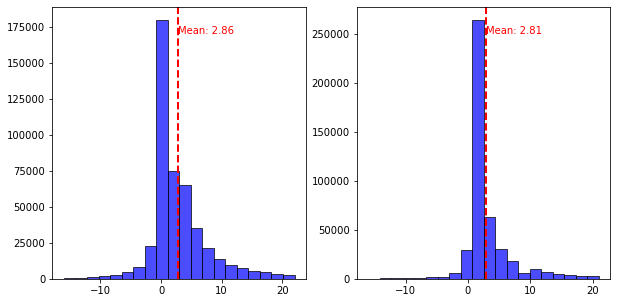

after removing 25846 outliers, which is 5.0% original
which have a mean of 68.75001934535325 & median of 39.0
the mean score of sarcastic comments is 2.8639075260819187 & median is 2.0
------------------------------------------------------------------------------------------
after removing 24611 outliers, which is 5.0% original
which have a mean of 92.26614115639349 & median of 41.0
the mean score of non-sarcastic comments is 2.8130120227892697 & median is 2.0


In [34]:
net_score_sarc = remove_outliers(sarc_df['score'], 4.5)
net_score_nsarc = remove_outliers(nsarc_df['score'], 6)

# Code to plot 1 x 2 grid
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
series_list = [net_score_sarc, net_score_nsarc]
axs_list = [axs[0], axs[1]]

for series, ax in zip(series_list, axs_list):
    # Calculate mean
    mean_value = np.mean(series)
    # Plot histogram
    ax.hist(series, bins=20, color='blue', edgecolor='black', alpha=0.7)
    # Plot mean line
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
    # Annotate mean value
    ax.text(mean_value, ax.get_ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red')
plt.show()


# additional code
iqr_analysis(sarc_df['score'], 4.5, 'sarcastic comments')
print('------------------------------------------------------------------------------------------')
iqr_analysis(nsarc_df['score'], 6, 'non-sarcastic comments')

In [35]:
crosswalk = subreddit_label_proportions[['subreddit', 'sarcasm_prop']].copy().reset_index(drop=True)

In [36]:
df5 = pd.merge(comments_df, crosswalk, on='subreddit', how='left')

In [37]:
mean_val = df5['sarcasm_prop_x'].mean()
df5['sarcasm_prop_x'] = df5['sarcasm_prop_x'].fillna(mean_val)
df5['is_toxic'] = df5['sarcasm_prop_x'].apply(lambda x : 0 if x <= mean_val else 1)

In [38]:
toxic_df = df5[df5['is_toxic'] == 1]
toxic_sarcasm_df = toxic_df[toxic_df['label'] == 1]
toxic_nsarcasm_df = toxic_df[toxic_df['label'] == 0]

wholesome_df = df5[df5['is_toxic'] == 0]
wholesome_sarcasm_df = wholesome_df[wholesome_df['label'] == 1]
wholesome_nsarcasm_df = wholesome_df[wholesome_df['label'] == 0]

In [39]:
# Create the series
toxic_sarcasm = remove_outliers(toxic_sarcasm_df['score'], 4.5)
toxic_nsarcasm = remove_outliers(toxic_nsarcasm_df['score'], 4.5)
wholesome_sarcasm = remove_outliers(wholesome_sarcasm_df['score'], 4.5)
wholesome_nsarcasm = remove_outliers(wholesome_nsarcasm_df['score'], 4.5)

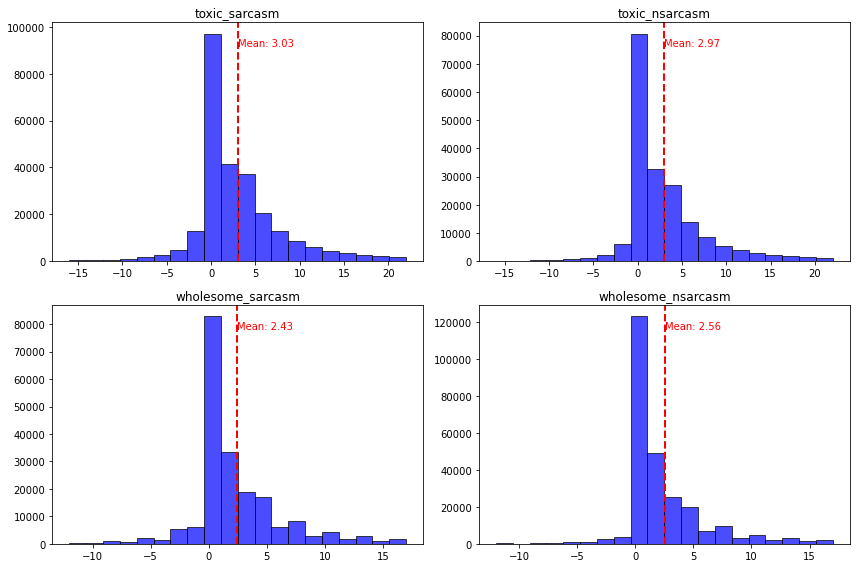

In [40]:
# Creating a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
series_list = [toxic_sarcasm , toxic_nsarcasm, wholesome_sarcasm , wholesome_nsarcasm]
axs_list = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
names_list = ['toxic_sarcasm' , 'toxic_nsarcasm', 'wholesome_sarcasm' , 'wholesome_nsarcasm']

# Plot each series in its respective subplot
for series, ax, name in zip(series_list, axs_list, names_list):
    mean_value = np.mean(series)
    ax.hist(series, bins=20, color='blue', edgecolor='black', alpha=0.7)
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
    ax.text(mean_value, ax.get_ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red')
    ax.set_title(name)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Conclusion

In [41]:
final_df_features = comments_df.drop(['subreddit', 'ups', 'downs', 'parent_comment'], axis=1).reset_index(drop=True)
final_df_features.head(3)

,label,comment,score,end_with_special_punctuation,sarcasm_prop,ln_comment_parent_ratio,subjectivity_category
0,0,NC and NH.,2,0,0.612595,-1.734601,0.0
1,0,You do know west teams play against west teams...,-4,1,0.530739,-0.656780,1.0
2,0,"They were underdogs earlier today, but since G...",3,0,0.513177,1.558145,1.0


# Write into CSV

In [43]:
final_df_features.to_csv('cs3244_sarcasm_feature_df1.csv', index = False, sep=',', encoding='utf-8')